In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns 
from matplotlib.gridspec import GridSpec

In [4]:
#read data into a pandas dataframe
yellow_taxi_trip_jan_2023_path = "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet"
yellow_taxi_trip_feb_2023_path = "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet"
jan_2023 = pd.read_parquet(yellow_taxi_trip_jan_2023_path)
feb_2023 = pd.read_parquet(yellow_taxi_trip_feb_2023_path)

In [5]:
print("jan shape", jan_2023.shape)
print("feb shape", feb_2023.shape)

jan shape (3066766, 19)
feb shape (2913955, 19)


In [6]:
jan_2023.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


In [7]:
feb_2023.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,1,2023-02-01 00:32:53,2023-02-01 00:34:34,2.0,0.30,1.0,N,142,163,2,4.4,3.50,0.5,0.0,0.0,1.0,9.40,2.5,0.00
1,2,2023-02-01 00:35:16,2023-02-01 00:35:30,1.0,0.00,1.0,N,71,71,4,-3.0,-1.00,-0.5,0.0,0.0,-1.0,-5.50,0.0,0.00
2,2,2023-02-01 00:35:16,2023-02-01 00:35:30,1.0,0.00,1.0,N,71,71,4,3.0,1.00,0.5,0.0,0.0,1.0,5.50,0.0,0.00
3,1,2023-02-01 00:29:33,2023-02-01 01:01:38,0.0,18.80,1.0,N,132,26,1,70.9,2.25,0.5,0.0,0.0,1.0,74.65,0.0,1.25
4,2,2023-02-01 00:12:28,2023-02-01 00:25:46,1.0,3.22,1.0,N,161,145,1,17.0,1.00,0.5,3.3,0.0,1.0,25.30,2.5,0.00


In [8]:

def data_info(df):
    """
    function takes a dataframe and returns a dataframe containing basic feature info of the dataframe
    """
    info_df = pd.DataFrame([df.isna().sum(),
                            round(df.isna().sum()*100 / df.shape[0],2), df.nunique(), df.dtypes], 
                            index=["missing_val","missing_val_percent","number_of_unique_val","data_types" ])
    
    return info_df



In [9]:
data_info(jan_2023).head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
missing_val,0,0,0,71743,0,71743,71743,0,0,0,0,0,0,0,0,0,0,71743,71743
missing_val_percent,0.0,0.0,0.0,2.34,0.0,2.34,2.34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.34,2.34
number_of_unique_val,2,1610975,1611319,10,4387,7,2,257,261,5,6873,68,10,4036,776,5,15871,3,3
data_types,int64,datetime64[us],datetime64[us],float64,float64,float64,object,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64


In [10]:
data_info(feb_2023).head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
missing_val,0,0,0,76817,0,76817,76817,0,0,0,0,0,0,0,0,0,0,76817,76817
missing_val_percent,0.0,0.0,0.0,2.64,0.0,2.64,2.64,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.64,2.64
number_of_unique_val,3,1493984,1493635,10,4314,7,2,258,261,5,6596,136,6,4009,726,5,15701,4,3
data_types,int32,datetime64[us],datetime64[us],float64,float64,float64,object,int32,int32,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64


In [11]:
#function to ingest data and output a pandas DataFrame
#with a target label
def create_target_label(*args):
    """
    This function takes in a variable number of monthly yello taxi data
    concatenates them, and create a target variable column by subtracting 
    the trip pock up from drop off
    """
    main_df = pd.DataFrame()

    #concatenate dataframes
    for arg in args:
        #rename the airport fee column to be consistent  
        arg = arg.rename(columns={"Airport_fee":"airport_fee"})
        main_df = pd.concat([main_df,arg])
    
    #drop the extra Airport_fee column created during the concatenation

    #create the duration
    main_df["trip_duration"] = main_df["tpep_dropoff_datetime"] - main_df["tpep_pickup_datetime"]

    return main_df

In [12]:
main_df = create_target_label(jan_2023, feb_2023)
main_df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_duration
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00,0 days 00:08:26
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00,0 days 00:06:19
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00,0 days 00:12:45
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25,0 days 00:09:37
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00,0 days 00:10:50


In [13]:
#print missing data
main_df.isna().sum()

VendorID                      0
tpep_pickup_datetime          0
tpep_dropoff_datetime         0
passenger_count          148560
trip_distance                 0
RatecodeID               148560
store_and_fwd_flag       148560
PULocationID                  0
DOLocationID                  0
payment_type                  0
fare_amount                   0
extra                         0
mta_tax                       0
tip_amount                    0
tolls_amount                  0
improvement_surcharge         0
total_amount                  0
congestion_surcharge     148560
airport_fee              148560
trip_duration                 0
dtype: int64

<Axes: >

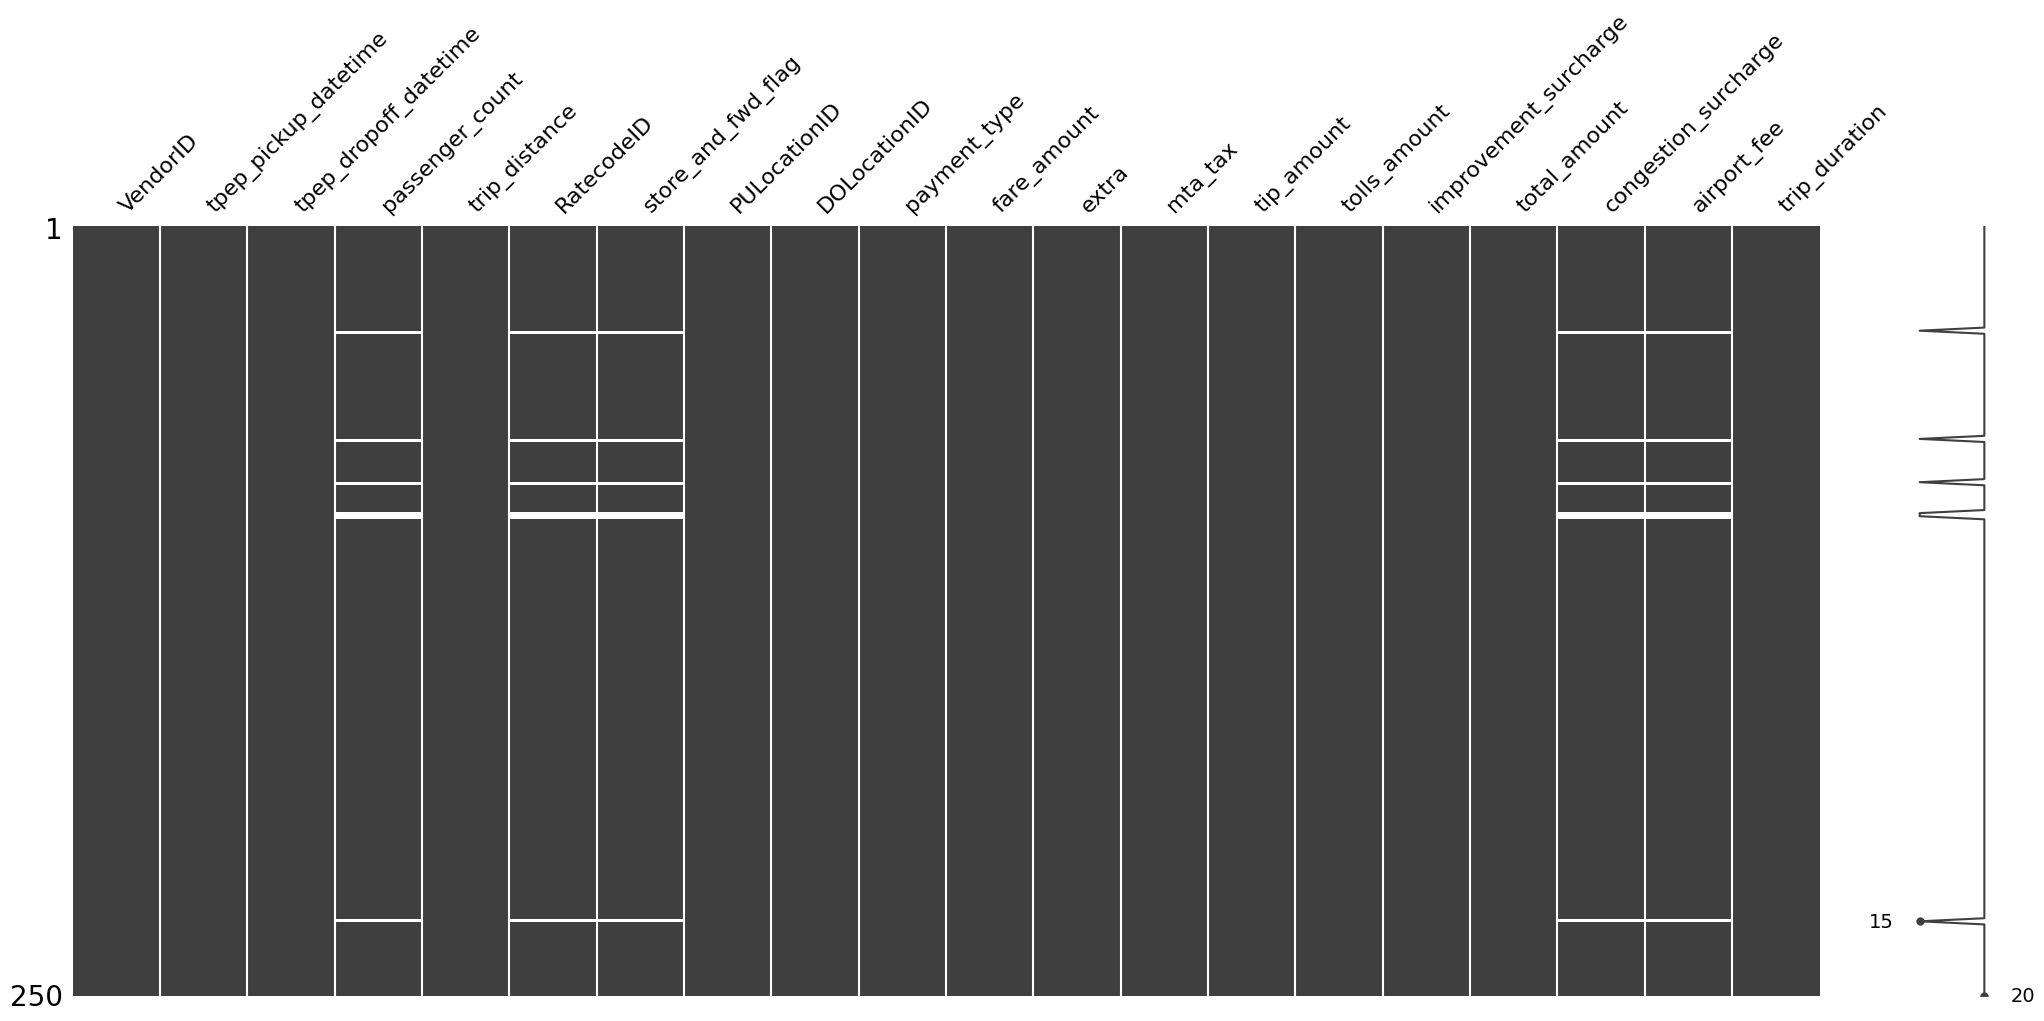

In [14]:
#visualize missing data 
msno.matrix(main_df.sample(250))

In [15]:
data_info(main_df)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_duration
missing_val,0,0,0,148560,0,148560,148560,0,0,0,0,0,0,0,0,0,0,148560,148560,0
missing_val_percent,0.0,0.0,0.0,2.48,0.0,2.48,2.48,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.48,2.48,0.0
number_of_unique_val,3,3104949,3104817,10,5043,7,2,260,261,5,8185,153,10,4706,1049,5,18704,4,3,10850
data_types,int64,datetime64[us],datetime64[us],float64,float64,float64,object,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,timedelta64[us]


In [16]:
# treat missing values
def treat_na(df):
    """
    This function converts features to appropriate data types,
    checks for percentage of missing values, drops features with missing values above 49 percent
    or else fill missing values with linear interpolation for continous data, and mode for categorical data
    """ 
    cat_1 = pd.CategoricalDtype(categories=[1,2,3,4,5,6], ordered=True)
    df["RatecodeID"] = df["RatecodeID"].astype(cat_1)
    df["payment_type"] = df["payment_type"].astype(cat_1)
    df["store_and_fwd_flag"] = df["store_and_fwd_flag"].astype("category")
    df["PULocationID"] = df["PULocationID"].astype("category")
    df["DOLocationID"] = df["DOLocationID"].astype("category")

    percent = round(df.isna().sum() * 100/df.shape[0] ,2)

    #loop through item
    for index, item in percent.items():
        if item > 49:
            df = df.drop(columns=[index])
        else:
            #fill missing categorical observations with mode
            if df[index].dtype == "category":
                df[index] = df[index].fillna(df[index].mode()[0])
            else: 
                #use linear interpolation for other data types
                df[index] = df[index].interpolate()
    return df
    

In [17]:
#check function
main_df_2 = treat_na(main_df)
data_info(main_df_2).head() 
    

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_duration
missing_val,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
missing_val_percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
number_of_unique_val,3,3104949,3104817,71753,5043,6,2,260,261,4,8185,153,10,4706,1049,5,18704,4,3,10850
data_types,int64,datetime64[us],datetime64[us],float64,float64,category,category,category,category,category,float64,float64,float64,float64,float64,float64,float64,float64,float64,timedelta64[us]


In [18]:
#Get statistical information of data
main_df_2.describe()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_duration
count,5.980721e+06,5980721,5980721,5.980721e+06,5.980721e+06,5.980721e+06,5.980721e+06,5.980721e+06,5.980721e+06,5.980721e+06,5.980721e+06,5.980721e+06,5.980721e+06,5.980721e+06,5980721
mean,1.730735e+00,2023-01-31 03:36:32.225056,2023-01-31 03:52:22.506285,1.367774e+00,3.857435e+00,1.829560e+01,1.548868e+00,4.880879e-01,3.376167e+00,5.150351e-01,9.817049e-01,2.696099e+01,2.285089e+00,9.969743e-02,0 days 00:15:50.281227
min,1.000000e+00,2008-12-31 23:01:42,2008-12-31 23:31:24,0.000000e+00,0.000000e+00,-9.000000e+02,-7.500000e+00,-5.000000e-01,-9.622000e+01,-6.500000e+01,-1.000000e+00,-7.575500e+02,-2.500000e+00,-1.250000e+00,-1 days +23:16:23
25%,1.000000e+00,2023-01-16 17:42:25,2023-01-16 17:58:21,1.000000e+00,1.060000e+00,8.600000e+00,0.000000e+00,5.000000e-01,1.000000e+00,0.000000e+00,1.000000e+00,1.548000e+01,2.500000e+00,0.000000e+00,0 days 00:07:11
50%,2.000000e+00,2023-01-31 10:49:32,2023-01-31 11:06:00,1.000000e+00,1.790000e+00,1.280000e+01,1.000000e+00,5.000000e-01,2.750000e+00,0.000000e+00,1.000000e+00,2.016000e+01,2.500000e+00,0.000000e+00,0 days 00:11:39
75%,2.000000e+00,2023-02-14 17:19:56,2023-02-14 17:38:17,1.000000e+00,3.300000e+00,2.050000e+01,2.500000e+00,5.000000e-01,4.200000e+00,0.000000e+00,1.000000e+00,2.870000e+01,2.500000e+00,0.000000e+00,0 days 00:18:32
max,6.000000e+00,2023-03-07 13:01:28,2023-03-07 13:11:17,9.000000e+00,3.350043e+05,2.203100e+03,2.080000e+01,5.316000e+01,4.829000e+02,1.969900e+02,1.000000e+00,2.208100e+03,2.750000e+00,1.250000e+00,6 days 23:09:11
std,4.480823e-01,NaN,NaN,8.852253e-01,2.589361e+02,1.765779e+01,1.791147e+00,1.020881e-01,3.832283e+00,2.020951e+00,1.852920e-01,2.200714e+01,7.577603e-01,3.436332e-01,0 days 00:42:42.935358


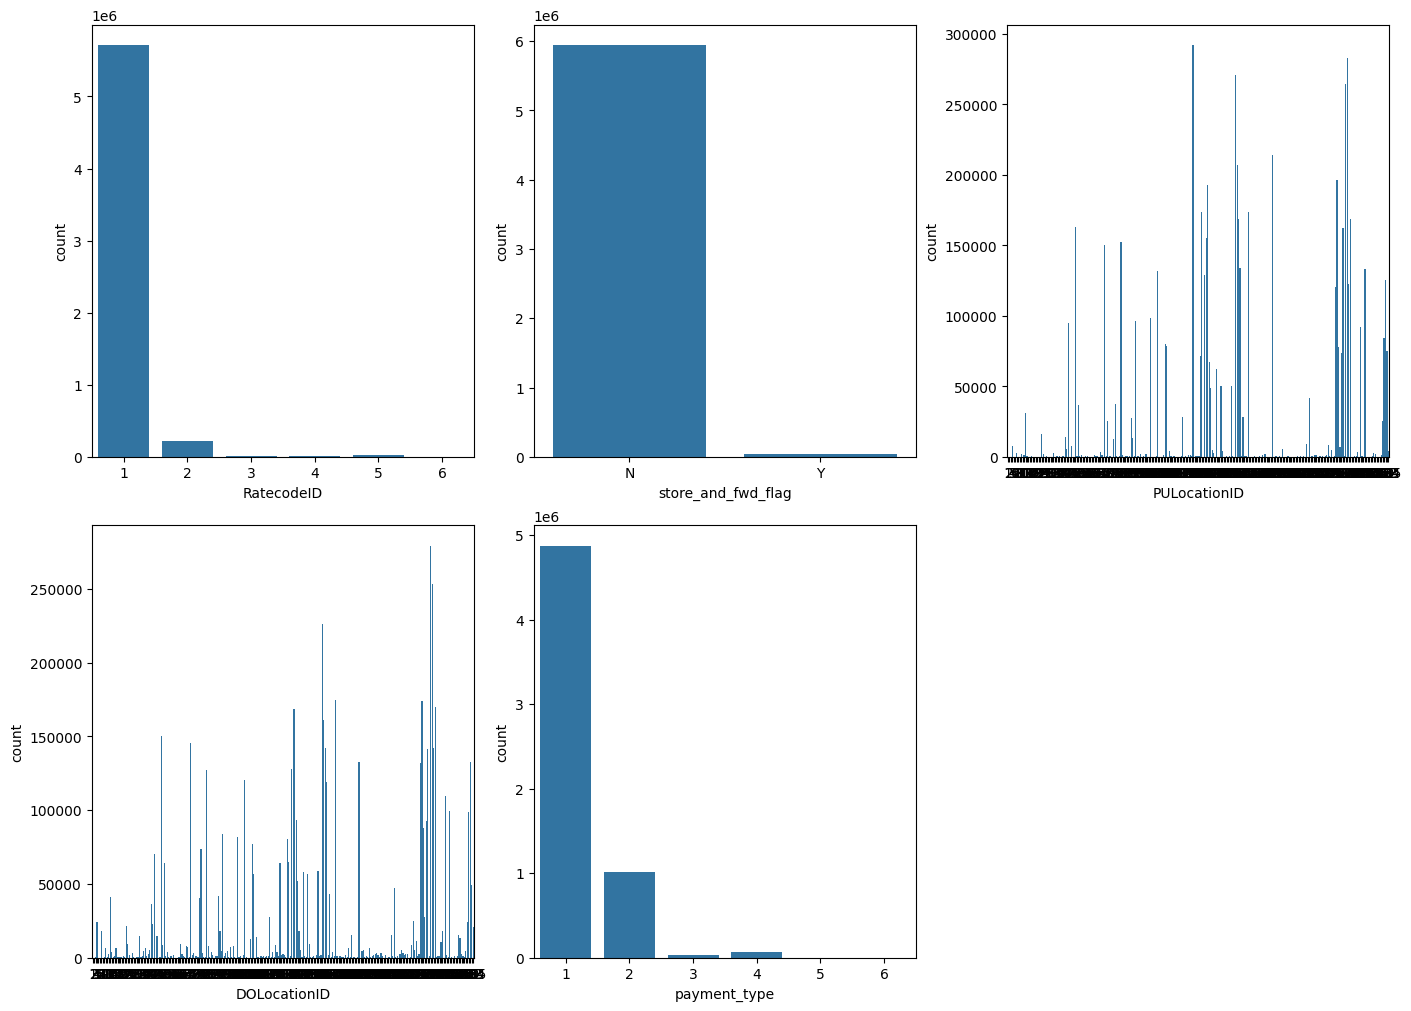

In [19]:
#plot data distribution for categorical data
cat_columns = [column for column, val in main_df_2.items() if val.dtype == "category"]

#pyplot figure object 
fig = plt.figure(layout="constrained", figsize = (14,10))
gs = GridSpec(2,3, figure=fig)
plot = 0 #count for the 

for i in range(2): #for row number
    for j in range(3): #for column number
        if plot < 5:
            ax_ = fig.add_subplot(gs[i,j]) # assign axes objects at current row and column
            sns.countplot(x= main_df_2.loc[:,cat_columns[plot]])
            plot += 1
plt.show()        
  

In [20]:
# plot distribution for numerical data
non_cat_columns = [column for column in main_df_2.columns if column not in cat_columns]
print(non_cat_columns)

['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'airport_fee', 'trip_duration']


In [ ]:
fig = plt.figure(layout="constrained", figure=(15,10))
gr_2 = GridSpec(5,3)

plot = 0 

for i in range(5): #for row number
    for j in range(3): #for column number
        if plot < len(non_cat_columns):
            ax_ = fig.add_subplot(gr_2[i,j]) # assign axes objects at current row and column
            sns.histplot(x= main_df_2.loc[:,non_cat_columns[plot]], bins=12, ax=ax_)
            plot += 1
plt.show()     
